## Imports

In [1]:
import tensorflow as tf
import keras 
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import StandardScaler 

import matplotlib.pyplot as plt

import numpy as np

import matplotlib.pyplot as plt

import os

from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.data_utils import *



%load_ext autoreload
%autoreload 2

2024-04-27 14:13:27.466907: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-27 14:13:27.497266: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-27 14:13:27.919568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Generating Data

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:87: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


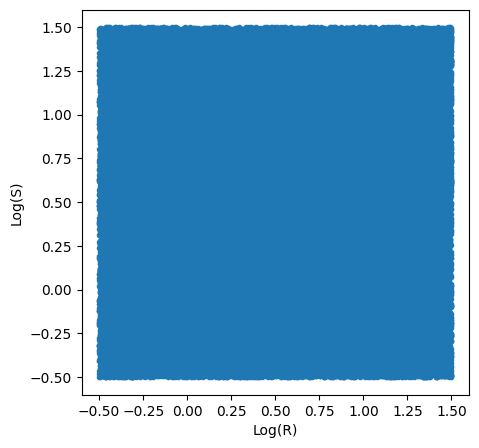

In [2]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 1.5)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 40_000, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

# Normalizing the data
x_scaler = StandardScaler().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = x_scaled_train
y_train = y_scaled_train


x_test = x_scaler.transform(etas_test)
y_test = y_scaler.transform(gs_test)

## Making Keras model

In [25]:
num_layers = 4
h_dim = 20
input_dim = 2
output_dim = 3
dropout_rate = 0.00
activation = 'relu'

model = keras.Sequential()

model.add(layers.InputLayer(input_shape=(input_dim,)))

for i in range(num_layers):
    if i == 0:
        model.add(layers.Dense(h_dim, activation=activation))
        model.add(layers.Dropout(dropout_rate))
    elif i == num_layers - 1:
        model.add(layers.Dense(output_dim, activation='linear', name=f'output_layer'))
    else:
        model.add(layers.Dense(h_dim, activation=activation, name=f'hidden_layer_{i}'))
        model.add(layers.Dropout(dropout_rate))

model.summary()


/home/codygrogan/.conda/envs/py311/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 963 (3.76 KB)

 Trainable params: 963 (3.76 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [26]:
cbs = [
    EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-3, restore_best_weights=True),
]
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-5), loss='mae')

history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test), callbacks=cbs)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 889us/step - loss: 0.5426 - val_loss: 0.3911
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - loss: 0.3804 - val_loss: 0.3421
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - loss: 0.3411 - val_loss: 0.3117
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - loss: 0.3118 - val_loss: 0.2882
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - loss: 0.2873 - val_loss: 0.2667
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - loss: 0.2642 - val_loss: 0.2486
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - loss: 0.2555 - val_loss: 0.2327
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - loss: 0.2302 - val_loss: 0.2181
Epoch 9/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - loss: 0.2196 - val_loss: 0.2053
Epoch 10/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - loss: 0.2051 - val_loss: 0.1940
Epoch 11/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 0.1952 - val_loss: 0.18

## Testing Output

  181/15313 ━━━━━━━━━━━━━━━━━━━━ 8s 559us/step

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:87: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


15313/15313 ━━━━━━━━━━━━━━━━━━━━ 7s 424us/step
Loss: 0.0030224585059526374


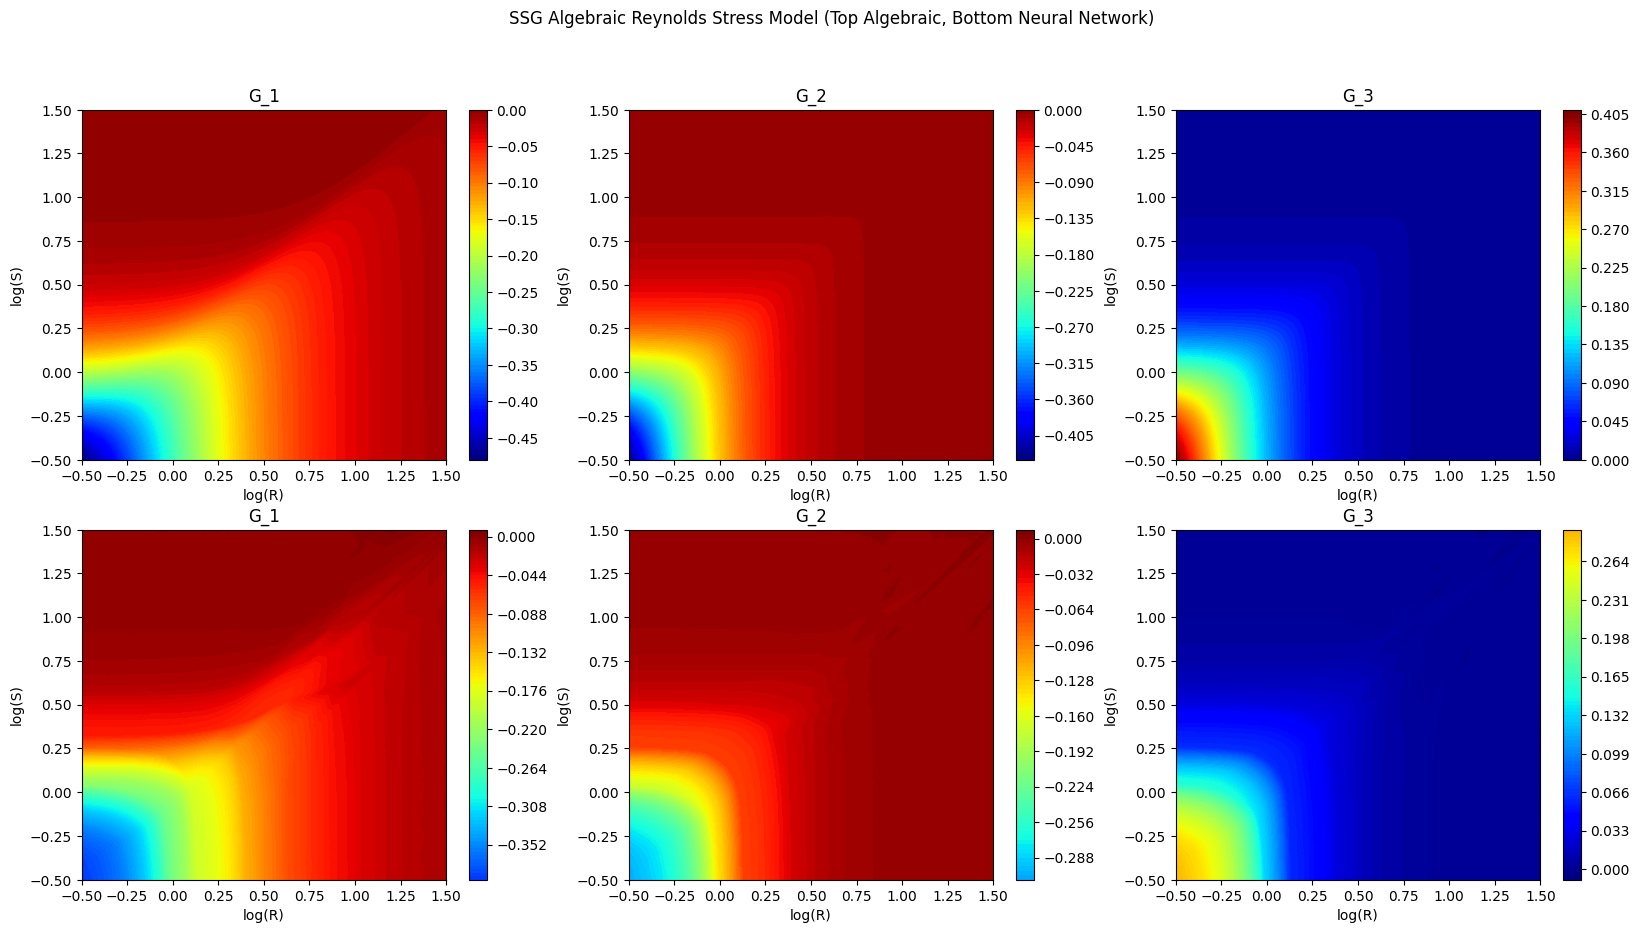

In [28]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG")
etas, G_s = gen(eta1, eta2)
target = G_s.T.reshape(3, dim, dim)

etas = x_scaler.transform(etas)

pred = model.predict(etas)

pred = y_scaler.inverse_transform(pred)


pred = pred.T.reshape(3, dim, dim)

loss = np.mean(np.abs(target - pred))
print(f"Loss: {loss}")


plot_heat_map_compare(x_grid, y_grid, target, pred)


## Evaluating Uncertainty

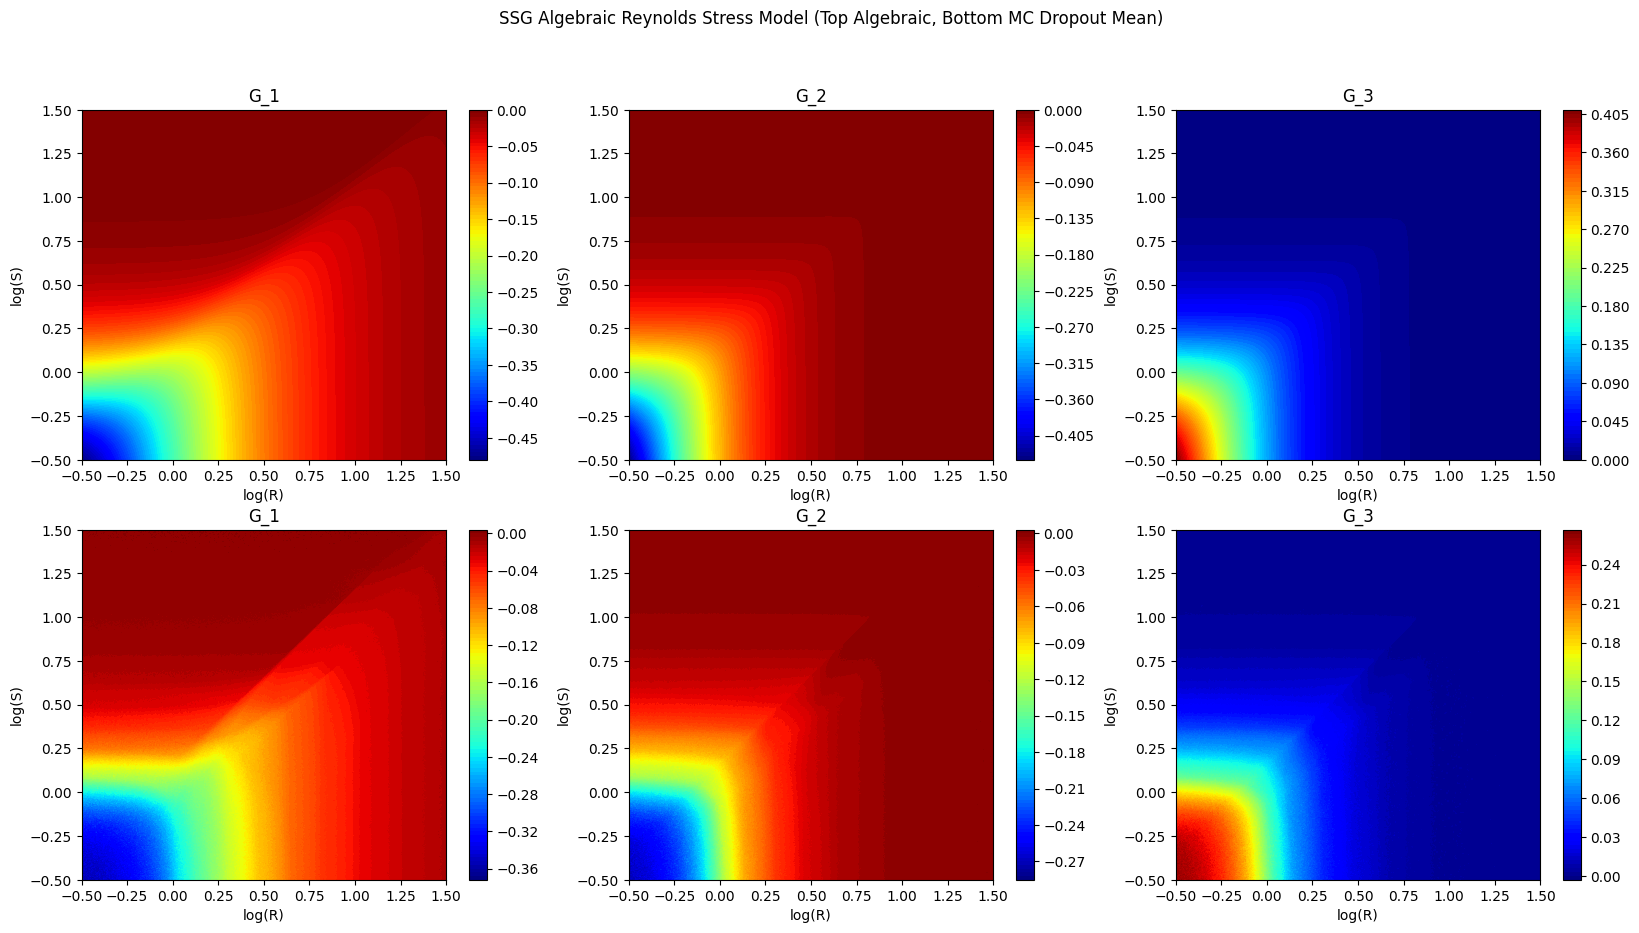

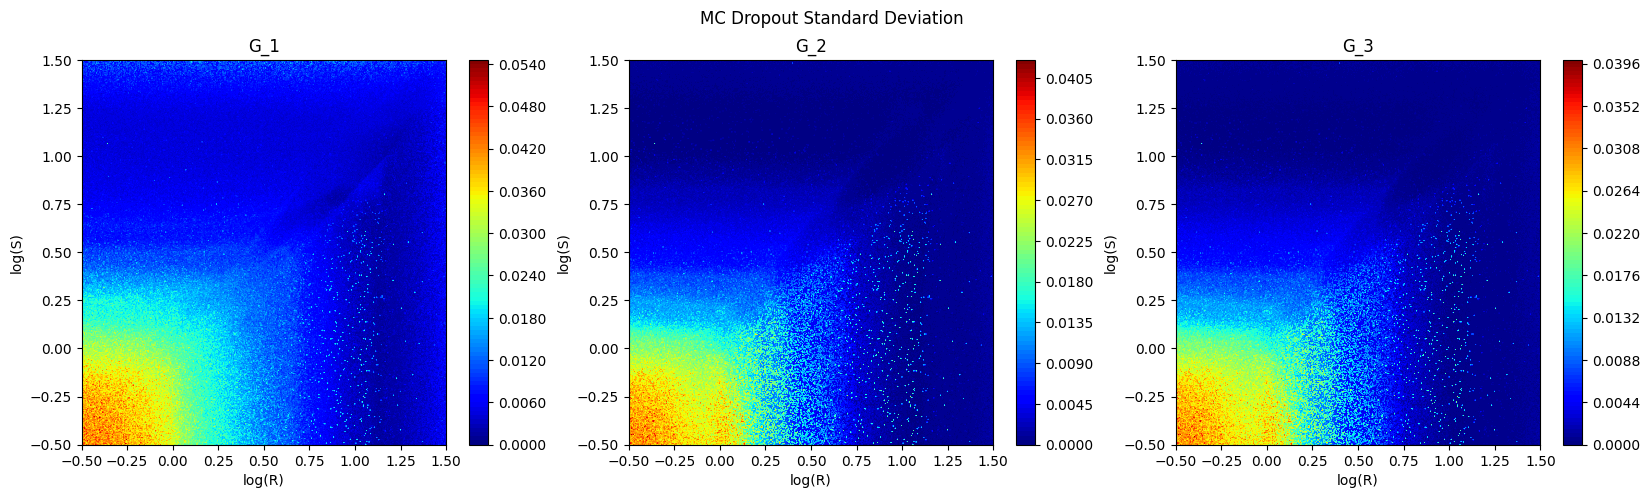

In [16]:
T = 50
predictions = np.zeros((T, dim*dim, 3))


for i in range(T):
    predictions[i] = y_scaler.inverse_transform(model(etas, training=True).numpy())


mean_pred = np.mean(predictions, axis=0)

variance_pred = np.std(predictions, axis=0)

plot_heat_map_compare(x_grid, y_grid, target, mean_pred.T.reshape(3, dim, dim), bottom_title="MC Dropout Mean")

plot_heat_map_3D(x_grid, y_grid, variance_pred.T.reshape(3, dim, dim), title="MC Dropout Standard Deviation")